In [20]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
import pyforest
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width',1000)

In [3]:
loan=pd.read_csv('loan.csv')
loan1=loan.copy()
# impute gender with most freq category
loan1['Gender']=loan1['Gender'].fillna('Male')
# impute gender with most freq category
loan1['Dependents']=loan1['Dependents'].fillna('0')
# impute gender with most freq category
loan1['Self_Employed']=loan1['Self_Employed'].fillna('No')
# as the distribution is skewed, we'll do for median imputation
loan1['LoanAmount']=loan1['LoanAmount'].fillna(loan1['LoanAmount'].median())
# we'll do for mean imputation
loan1['Loan_Amount_Term']=loan1['Loan_Amount_Term'].fillna(loan1['Loan_Amount_Term'].mean())
# impute gender with most freq category
loan1['Credit_History']=loan1['Credit_History'].fillna(1.0)
# impute gender with most freq category
loan1['Married']=loan1['Married'].fillna('Yes')
# drop loanid
loan1.drop('Loan_ID',axis=1,inplace=True)

<IPython.core.display.Javascript object>

In [4]:
from sklearn.preprocessing import LabelEncoder
def le(df,col):
    lab=LabelEncoder()
    df[col]=pd.Series(lab.fit_transform(df[col]))

In [5]:
le(loan1,'Gender')
le(loan1,'Married')
le(loan1,'Dependents')
le(loan1,'Education')
le(loan1,'Self_Employed')
le(loan1,'Property_Area')
le(loan1,'Loan_Status')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
from scipy.stats import zscore
z=np.abs(zscore(loan1))
loan1=loan1[(z<3).all(axis=1)]

x=loan1.drop('Loan_Status',axis=1)
y=loan1['Loan_Status']

<IPython.core.display.Javascript object>

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict,cross_validate
from sklearn.metrics import roc_curve, roc_auc_score

# Now, let's define some functions to reuse them
def fitc(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    
def get_scorec(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    train_score=m.score(x_train,y_train)
    pred=m.predict(x_test)
    test_score=accuracy_score(pred,y_test)
    return train_score,test_score

def get_predc(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    return pred

def get_metricsc(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    acc=accuracy_score(pred,y_test)
    conf=confusion_matrix(pred,y_test)
    clas=classification_report(pred,y_test)
    return acc,conf,clas

from sklearn.model_selection import GridSearchCV
def gridcvc(m,p,x,y):
    gkb=GridSearchCV(m,p,n_jobs=-1,cv=5,scoring='accuracy')
    gkb.fit(x,y)
    return gkb.best_params_


from sklearn.model_selection import RandomizedSearchCV
def randomcvc(m,p,x,y):
    from sklearn.model_selection import RandomizedSearchCV
    gkb=RandomizedSearchCV(estimator=m,param_distributions=p,
                          cv=5,n_iter=75,
                          n_jobs=-1, verbose=5,return_train_score=True,random_state=45)
    gkb.fit(x,y)
    return gkb.best_params_

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
def bfec(m,x,y,k):
    sf=sfs(m, k_features=k, forward=False, cv=5, n_jobs=-1)
    sf.fit(x,y)
    feat_names=list(sf.k_feature_names_)
    xbfe=x[feat_names]
    return xbfe

def ffsc(m,x,y,k):
    sf=sfs(m, k_features=k, forward=True, cv=5, n_jobs=-1)
    sf.fit(x,y)
    feat_names=list(sf.k_feature_names_)
    xffs=x[feat_names]
    return xffs

from sklearn.decomposition import PCA
def nforpcac(x):
    pca=PCA().fit(x)
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
    plt.xlabel('No of Components')
    plt.ylabel('Variance')
    plt.axhline(y=95, color='r', linestyle='--')
    plt.show()
    
def pcac(m,x,n):
    pca=PCA(n_components=n)
    xpca=pd.DataFrame(pca.fit_transform(x))
    return xpca

def crossc(m,x,y,c=5):
    score=cross_val_score(m,x,y,cv=c,n_jobs=-1)
    return (score.mean(), score.std())

from sklearn.preprocessing import StandardScaler
def stdc(x):
    scx=StandardScaler()
    xs=pd.DataFrame(scx.fit_transform(x), columns=x.columns)
    return xs

from sklearn.preprocessing import MinMaxScaler
def mmc(x):
    mm=MinMaxScaler()
    xm=pd.DataFrame(mm.fit_transform(x), columns=x.columns)
    return xm

def modified_bfec(m,x,y,k):
    sf=sfs(m, k_features=k, forward=False, cv=5, n_jobs=-1)
    sf.fit(x,y)
    feat_names=list(sf.k_feature_names_)
    xbfe=x[feat_names]
    x_train, x_test, y_train, y_test=train_test_split(xbfe,y,test_size=0.25,random_state=45,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    test_score=accuracy_score(pred,y_test)
    return test_score

def modified_ffsc(m,x,y,k):
    sf=sfs(m, k_features=k, forward=True, cv=5, n_jobs=-1)
    sf.fit(x,y)
    feat_names=list(sf.k_feature_names_)
    xffs=x[feat_names]
    x_train, x_test, y_train, y_test=train_test_split(xffs,y,test_size=0.25,random_state=45,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    test_score=accuracy_score(pred,y_test)
    return test_score

def modified_pcac(m,x,y,n):
    pca=PCA(n_components=n)
    xpca=pd.DataFrame(pca.fit_transform(x))
    x_train, x_test, y_train, y_test=train_test_split(xpca,y,test_size=0.25,random_state=45,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    test_score=accuracy_score(pred,y_test)
    return test_score

def ttsc(x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    return x_train, x_test, y_train, y_test

def classification(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    clas=classification_report(pred,y_test)
    return clas

lrc=LogisticRegression(n_jobs=-1,random_state=45)
dtc=DecisionTreeClassifier(random_state=45)
svc=SVC(random_state=45)
knnc=KNeighborsClassifier(n_jobs=-1)
rfc=RandomForestClassifier(n_jobs=-1,random_state=45)
gbc=GradientBoostingClassifier(random_state=45)
xgbc=XGBClassifier(n_jobs=-1,random_state=45)
adac=AdaBoostClassifier(random_state=45)
gnb=GaussianNB()
mnb=MultinomialNB()

In [8]:
xs=stdc(x)
x_sk=x.copy()

# x_sk['ApplicantIncome'].min(), x_sk['ApplicantIncome'].max()
x_sk['ApplicantIncome']=np.log(x_sk['ApplicantIncome'])
# skewness reduced to -0.20
# x_sk['CoapplicantIncome'].min(), x_sk['CoapplicantIncome'].max()
x_sk['CoapplicantIncome']=np.cbrt(x_sk['CoapplicantIncome'])
# skewness reduced to -0.03
# x_sk['LoanAmount'].min(), x_sk['LoanAmount'].max()
x_sk['LoanAmount']=np.cbrt(x_sk['LoanAmount'])
# skewness reduced to 0.05
# x_sk['Loan_Amount_Term'].min(), x_sk['Loan_Amount_Term'].max()
x_sk['Loan_Amount_Term']=np.power(x_sk['Loan_Amount_Term'],2.5)
# skewness reduced to 0.05
# x_sk['Dependents'].min(), x_sk['Dependents'].max()
x_sk['Dependents']=np.power(x_sk['Dependents'],1/5)
# skewness reduced to 0.43

xs_sk=stdc(x_sk)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# LR

In [9]:
# LR with xs_sk 0.8194444444444444, 0.8137931034482758

In [10]:
# lrc=LogisticRegression(n_jobs=-1,random_state=45)

In [11]:
# Individual Model Pipeline:
# 1. feature selection
# 2. Hyper parameter tuning
# 3. Boosting
# 4. Cross Validation
# 5. Evaluation Metrics

In [66]:
# lets apply BFE
# there are 11 features
for i in range(7,12):
    print(i," ",modified_bfec(lrc,xs_sk,y,i))

7   0.8137931034482758
8   0.8137931034482758
9   0.8137931034482758
10   0.8137931034482758
11   0.8137931034482758


In [67]:
# no change in score

In [68]:
# lets apply FFS
# there are 11 features
for i in range(7,12):
    print(i," ",modified_ffsc(lrc,xs_sk,y,i))

7   0.8137931034482758
8   0.8137931034482758
9   0.8137931034482758
10   0.8137931034482758
11   0.8137931034482758


In [69]:
# same score

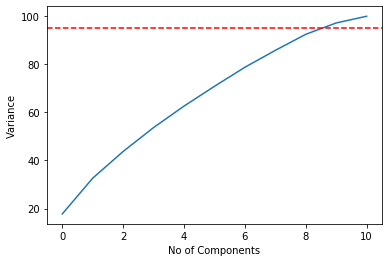

In [70]:
# lets apply PCA
nforpcac(xs_sk)

In [71]:
# take n from 8 to 12
for i in range(4,12):
        print(i," ",modified_pcac(lrc,xs_sk,y,i))

4   0.7241379310344828
5   0.8137931034482758
6   0.8137931034482758
7   0.8137931034482758
8   0.8137931034482758
9   0.8137931034482758
10   0.8137931034482758
11   0.8137931034482758


In [72]:
# the score is same

In [73]:
# lets tune the model

In [27]:
param_lrc={'warm_start':[True,False],
           'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
randomcvc(lrc,param_lrc,xs_sk,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    4.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.8s finished


{'warm_start': True, 'solver': 'newton-cg'}

In [92]:
lrc1=LogisticRegression(random_state=45,n_jobs=-1,solver= 'newton-cg', warm_start= True)

In [30]:
param_lrc1={'tol':[1e-7,1e-6,1e-5,1e-4,1e-3],'C':[0.01,0.02,0.04,0.05,0.1]}
randomcvc(lrc1,param_lrc1,xs_sk,y)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 118 out of 125 | elapsed:    3.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    3.9s finished


{'tol': 1e-07, 'C': 0.01}

In [93]:
lrc2=LogisticRegression(random_state=45,n_jobs=-1,solver= 'newton-cg', warm_start= True,tol= 1e-07, C= 0.01)

In [76]:
get_scorec(lrc2,xs_sk,y)

(0.8194444444444444, 0.8137931034482758)

In [77]:
# the score is same

In [94]:
lrc3=LogisticRegression(random_state=45,n_jobs=-1, warm_start= True,tol= 1e-07, C=2)
get_scorec(lrc3,xs_sk,y)

(0.8194444444444444, 0.8137931034482758)

In [36]:
AdaBoostClassifier?

In [95]:
adac=AdaBoostClassifier(random_state=45,base_estimator=lrc2)

In [38]:
# lets try to boost it
param_ada={'n_estimators':range(50,400,100),'learning_rate':[0.01,0.1,0.5,1]}
randomcvc(adac,param_ada,xs_sk,y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  7.9min finished


{'n_estimators': 350, 'learning_rate': 1}

In [96]:
adalrc=AdaBoostClassifier(random_state=45,base_estimator=lrc2,n_estimators=350,learning_rate=1)
get_scorec(adalrc,xs_sk,y)

(0.8194444444444444, 0.8137931034482758)

In [97]:
adalrc1=AdaBoostClassifier(random_state=45,base_estimator=lrc2,n_estimators=350,learning_rate=1.5)
get_scorec(adalrc1,xs_sk,y)

(0.8194444444444444, 0.8137931034482758)

In [44]:
# the score is not improving

In [84]:
coeff=lrc2.coef_
coeff=coeff.ravel()
coeff

array([-0.06042258,  0.02427394,  0.06313648, -0.09460364,  0.01574008,
       -0.0429713 ,  0.03756406, -0.03368569, -0.02925206,  0.56034302,
        0.031851  ])

In [85]:
co1=pd.DataFrame({'Variables':xs_sk.columns,
             'Coef':coeff})
co1

,Variables,Coef
0,Gender,-0.060423
1,Married,0.024274
2,Dependents,0.063136
3,Education,-0.094604
4,Self_Employed,0.015740
5,ApplicantIncome,-0.042971
6,CoapplicantIncome,0.037564
7,LoanAmount,-0.033686
8,Loan_Amount_Term,-0.029252
9,Credit_History,0.560343


In [86]:
co1.sort_values(by='Coef')

,Variables,Coef
3,Education,-0.094604
0,Gender,-0.060423
5,ApplicantIncome,-0.042971
7,LoanAmount,-0.033686
8,Loan_Amount_Term,-0.029252
4,Self_Employed,0.015740
1,Married,0.024274
10,Property_Area,0.031851
6,CoapplicantIncome,0.037564
2,Dependents,0.063136


In [87]:
# lets drop self employed and married
xs_sk_red=xs_sk.drop(['Self_Employed','Married'],axis=1)

In [88]:
xs_sk.shape,xs_sk_red.shape

((577, 11), (577, 9))

In [89]:
y.shape

(577,)

In [98]:
get_scorec(lrc,xs_sk_red,y)

(0.8194444444444444, 0.8137931034482758)

In [99]:
# the score didn't improved

In [101]:
# lets cross validate lrc2,xs_sk_y
for i in range(2,13):
    print(i," ",crossc(lrc2,xs_sk,y,i))

2   (0.8024437716262975, 0.010056228373702403)
3   (0.8181283852824421, 0.021658092211660564)
4   (0.8163994051925086, 0.023383926135853113)
5   (0.8181811725716088, 0.029053552755050584)
6   (0.8181147133297161, 0.03052825863543639)
7   (0.8182638930998224, 0.036665695607728775)
8   (0.8182405888910327, 0.039192242492883944)
9   (0.8181297483380816, 0.03867307550673175)
10   (0.8182017543859649, 0.034920966201780826)
11   (0.8180926341303699, 0.037256518428866084)
12   (0.8180166570174169, 0.036189776984258654)


In [102]:
# best score is at cv=3

In [103]:
# lets make AUC_ROC curve

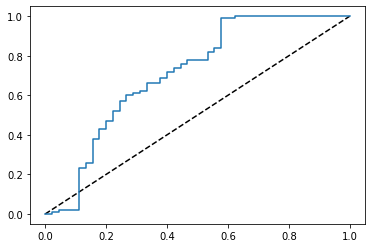

In [108]:
xtr,xte,ytr,yte=ttsc(xs_sk,y)
lrc2.fit(xtr,ytr)
y_pred_pro=lrc2.predict_proba(xte)[:,1]
fpr,tpr,threshold=roc_curve(yte,y_pred_pro)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr,tpr,label='LRC')
plt.show()

In [110]:
roc_auc_score(yte,y_pred_pro)

0.7104444444444444

In [111]:
# lets save the model

In [112]:
# lets save the cross validated model
cv_results = cross_validate(lrc2, xs_sk ,y, cv=3, return_estimator=True)
lrc_fit = cv_results['estimator']
print(lrc_fit)

(LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=45,
                   solver='newton-cg', tol=1e-07, verbose=0, warm_start=True), LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=45,
                   solver='newton-cg', tol=1e-07, verbose=0, warm_start=True), LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=45,
                   solver='newton-cg', tol=1e-07, verbose=0, warm_start=True))


In [113]:
lrc_fit=lrc_fit[0]

In [114]:
import joblib
joblib.dump(lrc_fit,'lrc_loan.pkl')

['lrc_loan.pkl']

In [115]:
crosspred=cross_val_predict(lrc2, xs_sk ,y,cv=3)

In [116]:
# metrics
classi=classification_report(y,crosspred)
conf=confusion_matrix(y,crosspred)
acc=accuracy_score(y,crosspred)
print(acc)
print(' ')
print(conf)
print(' ')
print(classi)

0.8180242634315424
 
[[ 79 100]
 [  5 393]]
 
              precision    recall  f1-score   support

           0       0.94      0.44      0.60       179
           1       0.80      0.99      0.88       398

    accuracy                           0.82       577
   macro avg       0.87      0.71      0.74       577
weighted avg       0.84      0.82      0.79       577



In [117]:
# lets check metrics of lrc2, xs_sk ,y
# Evaluation metrics
acc, conf, clas=get_metricsc(lrc2, xs_sk ,y)
print(acc)
print(' ')
print(conf)
print(' ')
print(clas)

0.8137931034482758
 
[[19  1]
 [26 99]]
 
              precision    recall  f1-score   support

           0       0.42      0.95      0.58        20
           1       0.99      0.79      0.88       125

    accuracy                           0.81       145
   macro avg       0.71      0.87      0.73       145
weighted avg       0.91      0.81      0.84       145



In [118]:
# precision of cross validated model is better
# it'll prevent false positive

In [119]:
# saving predictions
prediction=pd.DataFrame(crosspred)
prediction.to_csv('pred_lrc_loan.csv')